<a href="https://colab.research.google.com/github/BrokenShell/DS-Unit-4-Sprint-1-NLP/blob/master/module1-text-data/LS_DS_411_Text_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells!

## After running the next cell...

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 826.9MB 6.8MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255078 sha256=26d8fc841e79d22947439d63272f5f929da502d35792376b60f8a600c2211f6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3xs8ytbn/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## ...restart the runtime!

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
!pip install IteratorAlgorithms  # I wrote this library!
!pip install squarify

import IteratorAlgorithms as ia
import squarify

In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from spacy.tokenizer import Tokenizer
from spacy.matcher import Matcher
from nltk.stem import PorterStemmer
import seaborn as sns
import altair as alt

In [ ]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"
shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


### Data Cleaning

In [ ]:
clean_shops = shops.copy()

clean_shops['star_rating'] = clean_shops['star_rating'].apply(lambda s: int(float(s.split()[0])))
clean_shops['star_rating'][0]

5

In [ ]:
clean_shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [ ]:
clean_shops['full_review_text'] = clean_shops['full_review_text'].apply(lambda s: ' '.join(s.split()[3:]))
clean_shops['full_review_text'][0]

'Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?'

### Functions

In [ ]:
def tokenize(text):
    tokens = re.sub(r'[^a-z A-Z]', '', text)
    tokens = tokens.lower().split()
    return tokens


def count(docs):
    word_counts = Counter()
    appears_in = Counter()
    total_docs = len(docs)
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    wc = wc.sort_values(by='rank')
    wc['cum_total'] = wc['pct_total'].cumsum()
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    return wc.sort_values(by='rank')

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

### Tokenizing Data

In [ ]:
token_shops = clean_shops.copy()
token_shops['tokens'] = token_shops['full_review_text'].apply(tokenize)

Splitting Good vs Bad Shops
- Good is 4 or 5 Stars
- Bad is 1-3 Stars

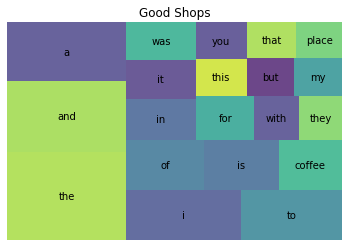

In [ ]:
good_shops = token_shops[token_shops['star_rating'] > 3]

gs = count(good_shops['tokens'])
gs_top20 = gs[gs['rank'] <= 20]
squarify.plot(sizes=gs_top20['pct_total'], label=gs_top20['word'], alpha=.8)
plt.title('Good Shops')
plt.axis('off')
plt.show()

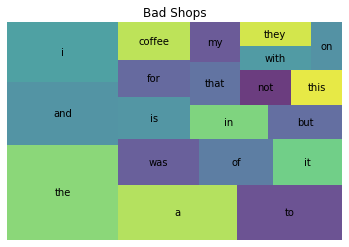

In [ ]:
bad_shops = token_shops[token_shops['star_rating'] < 4]

bs = count(bad_shops['tokens'])
bs_top20 = bs[bs['rank'] <= 20]
squarify.plot(sizes=bs_top20['pct_total'], label=bs_top20['word'], alpha=.8)
plt.title('Bad Shops')
plt.axis('off')
plt.show()

> The data is nearly meaningless due to the filler words like "the", "for" and others. Stop words to the rescue!

### Fresh Data

In [ ]:
clean_shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,Love love loved the atmosphere! Every corner o...,5
1,The Factory - Cafe With a Soul,"Date Night: Austin, Ambiance in Austin BEAUTIF...",4
2,The Factory - Cafe With a Soul,Listed in Brunch Spots I loved the eclectic an...,4
3,The Factory - Cafe With a Soul,decor! Good drinks Nice seating However... Jus...,2
4,The Factory - Cafe With a Soul,They are located within the Northcross mall sh...,4


In [ ]:
def clean_str(s):
    return re.sub(r'[^a-z ]', '', s.lower())

In [ ]:
# Custom Stop Words
stop_words = {
    'a', 'to', 'the', 'and', 'was', 'but', 'it', 'i', 'my', 'place',
    'this', 'in', 'of', 'on', 'they', 'that', 'with', 'for', 'is',
    'are', 'so', 'you', 'have', 'at', 'their', 'had', 'be', 'not', 'didnt',
    'there', 'if', 'like', 'its', 'just', 'or', 'all', 'out', 'here',
    'from', 'get', 'as', 'very', 'me', 'one', 'back', 'some', 'really', 
    'also', 'were', 'an', 'can', 'when', 'up', 'im', 'which', 'go', 'food',
    'about', 'shop', 'too', 'more', 'we', 'what', 'would', 'your', 'dont',
    'by', 'people', 'dont', 'only', 'ive', 'will', 'has', 'work', 'order',
    'other', 'come', 'try', 'well', 'because', 'definitely', 'even', 'got',
    'do', 'been', 'than', 'always', 'spot', 'make', 'much', 'day', 'okay',
    'ordered', 'small', 'know', 'lot', 'them', 'sweet', 'made', 'pretty',
    'see', 'first', 'over', 'want', 'after', 'while', 'right', 'awesome',
    'think', 'area', 'around', 'how', 'inside', 'am', 'two', 'ask', 'great',
    'wasnt'
}

In [ ]:
STOP_WORDS = nlp.Defaults.stop_words.union(stop_words)

In [ ]:
# Tokenizer Pipe
pipe_shops = clean_shops.copy()
pipe_shops['full_review_text'] = pipe_shops['full_review_text'].apply(clean_str)
tokenizer = Tokenizer(nlp.vocab)

tokens = []
for doc in tokenizer.pipe(pipe_shops['full_review_text'], batch_size=500):
    tokens.append(
        ia.difference({token.lemma_ for token in doc if token.lemma_ != ' '}, STOP_WORDS)
    )

pipe_shops['tokens'] = tokens
pipe_shops['tokens'].head()

0    {corner, swing, hope, style, minute, feather, ...
1    {prepare, ambiance, penny, waffle, dessert, lo...
2    {swing, outside, worth, item, decor, thoroughl...
3    {music, decor, odd, follow, service, average, ...
4    {item, choose, pick, face, upload, new, east, ...
Name: tokens, dtype: object

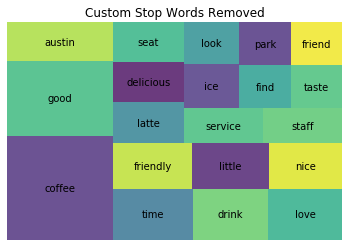

In [ ]:
wc = count(pipe_shops['tokens'])
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.title('Custom Stop Words Removed')
plt.axis('off')
plt.show()

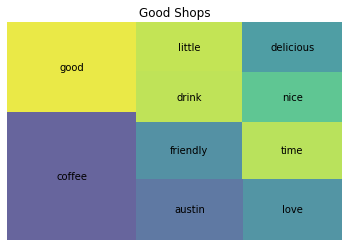

In [ ]:
good_shops = pipe_shops[pipe_shops['star_rating'] > 3]

gs = count(good_shops['tokens'])
gs_top20 = gs[gs['rank'] <= 10]
squarify.plot(sizes=gs_top20['pct_total'], label=gs_top20['word'], alpha=.8)
plt.title('Good Shops')
plt.axis('off')
plt.show()

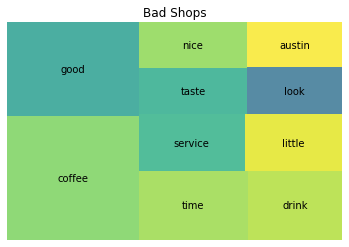

In [ ]:
bad_shops = pipe_shops[pipe_shops['star_rating'] < 4]

bs = count(bad_shops['tokens'])
bs_top20 = bs[bs['rank'] <= 10]
squarify.plot(sizes=bs_top20['pct_total'], label=bs_top20['word'], alpha=.8)
plt.title('Bad Shops')
plt.axis('off')
plt.show()

## Visualize the words with the greatest difference in counts between 'good' & 'bad'.

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [ ]:
gwc = count(good_shops['tokens'])
bwc = count(bad_shops['tokens'])

In [ ]:
diff = pd.DataFrame(columns=['word', 'rate diff', 'goodbad'])
words, rates, goodbads = [], [], []

# Get all the good word counts and subtract the bad count 
for word in gwc['word']:
    a = gwc[gwc['word'] == word]['appears_in_pct'].values[0]
    if word in bwc['word'].values:
        b = bwc[bwc['word'] == word]['appears_in_pct'].values[0]
    else:
        b = 0
    words.append(word)
    c = a - b
    rates.append(abs(c))
    goodbads.append('Good' if c > 0.06 else 'Bad' if c < -0.06 else 'Meh')

# Get all the bad word counts that aren't in the good words
for word in bwc['word']:
    if word not in gwc['word'].values:
        words.append(word)
        rates.append(bwc[bwc['word'] == word]['appears_in_pct'].values[0])
        goodbads.append('Bad')

diff['word'] = words
diff['rate diff'] = rates
diff['goodbad'] = goodbads

In [ ]:
short_list = diff.sort_values(by='rate diff', ascending=False).head(20).reset_index().drop(columns=['index'])
print(short_list)
# short_list.to_csv("shortlist.csv")

          word  rate diff goodbad
0    delicious   0.132392    Good
1     friendly   0.105599    Good
2         love   0.095821    Good
3      service   0.091538     Bad
4       austin   0.088376    Good
5        taste   0.081122     Bad
6     customer   0.081039     Bad
7        amaze   0.077844    Good
8        maybe   0.073528     Bad
9      perfect   0.072600    Good
10    favorite   0.070333    Good
11        time   0.068377     Bad
12       wrong   0.066284     Bad
13        star   0.065404     Bad
14      review   0.062238     Bad
15         pay   0.061724     Bad
16         bad   0.060460     Bad
17      minute   0.059757     Meh
18        rude   0.059236     Meh
19  experience   0.057502     Meh


In [ ]:
domain = ['Good', 'Bad', 'Meh']
range_ = ['green', 'brown', 'orange']
alt.Chart(short_list, title="Good, Bad & Meh").mark_circle(size=250).encode(
    x=alt.X('word:O', sort='y', title=""),
    y=alt.Y('rate diff:Q', title="Absolute Relative Difference"),
    color=alt.Color('goodbad:N', title="", scale=alt.Scale(domain=domain, range=range_)),
    tooltip=['word', 'goodbad'],
).properties(width=630, height=420)

alt.Chart(...)

# Summary
It seems that the best Coffee Shops are described as friendly and delicious! When a bad review is given words such as 'service' and 'customer' are often in the text.

## Stretch Goals

* [ ] Analyze another corpus of documents - such as Indeed.com job listings ;).
* [x] Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* [x] Try to build a plotly ~~dash~~ discord app with your text data 
    - [Discord NLP Bot](https://github.com/BrokenShell/Discord-NLP-Bot)



### Named Entities

In [ ]:
import spacy

nlp = spacy.load("en_core_web_lg")
text = "My name is Robert Sharp, I love Python3 and Picaso."
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)

Robert Sharp PERSON
Python3 FAC
Picaso PERSON


In [ ]:
matcher = Matcher(nlp.vocab)
doc = nlp(
    "After making the iOS update you won't notice a radical "
    "system-wide redesign: nothing like the aesthetic upheaval "
    "we got with iOS 7. Most of iOS 11's furniture remains the "
    "same as in iOS 10. But you will discover some tweaks once "
    "you delve a little deeper."
)

# Write a pattern for full iOS versions
pattern = [{"TEXT": "iOS"}, {"IS_DIGIT": True}]

# Add the pattern to the matcher and apply
matcher.add("IOS_VERSION", None, pattern)
matches = matcher(doc)

# Iterate over the matches and print
print("Total matches found:", len(matches))
for _, start, end in matches:
    print("Match found:", doc[start:end].text)

Total matches found: 3
Match found: iOS 7
Match found: iOS 11
Match found: iOS 10


### Noun Chunks

In [ ]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

doc = nlp(
    "Features of the app include a beautiful design, smart search, automatic "
    "labels and optional voice responses. And we will build it in a timely "
    "manner or the undead king will prevail."
)

# Write a pattern for adjective plus one or two nouns
pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN", "OP": "?"}]

# Add the pattern to the matcher and apply the matcher to the doc
matcher.add("ADJ_NOUN_PATTERN", None, pattern)
matches = matcher(doc)
print("Total matches found:", len(matches))

# Iterate over the matches and print the span text
for match_id, start, end in matches:
    print("Match found:", doc[start:end].text)

Total matches found: 6
Match found: beautiful design
Match found: smart search
Match found: automatic labels
Match found: optional voice responses
Match found: timely manner
Match found: undead king


These are amazingly awesome!!!